In [162]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import matplotlib.pyplot as plt

In [163]:
# AR

# ArmaProcess로 모형 생성하고 nobs 만큼 샘플 생성 

def gen_arma_samples (ar,ma,nobs):
    arma_model = ArmaProcess(ar=ar, ma=ma) 
    
    # 모형 정의 
    arma_samples = arma_model.generate_sample(nobs) 
    
    # 샘플 생성 
    return arma_samples

In [164]:
# drift가 있는 모형은 ArmaProcess에서 처리가 안 되어서 수동으로 정의해줘야 함 

def gen_random_walk_w_drift(nobs,drift):
    init = np.random.normal(size=1, loc = 0)
    e = np.random.normal(size=nobs, scale =1) 
    y = np.zeros(nobs)
    y[0] = init
    for t in (1,nobs):
        y[t] = drift + 1 * y[t-1] + e[t] 
        return y

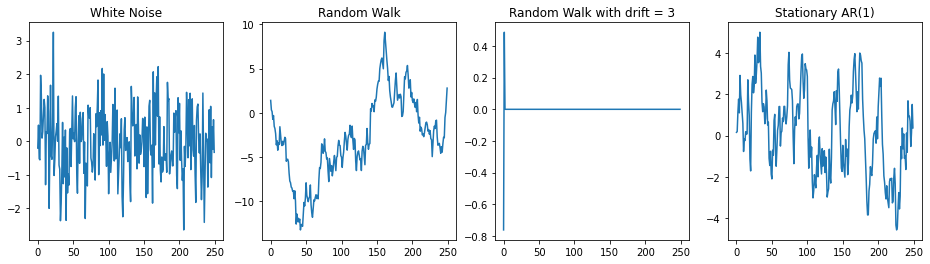

In [165]:
np.random.seed(12345)

white_noise= gen_arma_samples(ar = [1], ma = [1], nobs = 250)
# y_t = epsilon_t

random_walk = gen_arma_samples(ar = [1,-1], ma = [1], nobs = 250) 
# (1 - L)y_t = epsilon_t

random_walk_w_drift = gen_random_walk_w_drift(250, 3) # 표류값
# y_t = 3 + y_{t-1} + epsilon_t

stationary_ar_1 = gen_arma_samples(ar = [1,-0.9], ma = [1],nobs=250) 
# (1 - 0.9L) y_t = epsilon_t

fig,ax = plt.subplots(1,4)
ax[0].plot(white_noise)
ax[0].set_title("White Noise")

ax[1].plot(random_walk)
ax[1].set_title("Random Walk")

ax[2].plot(random_walk_w_drift)
ax[2].set_title("Random Walk with drift = 3")

ax[3].plot(stationary_ar_1) 
ax[3].set_title("Stationary AR(1)")

fig.set_size_inches(16,4)

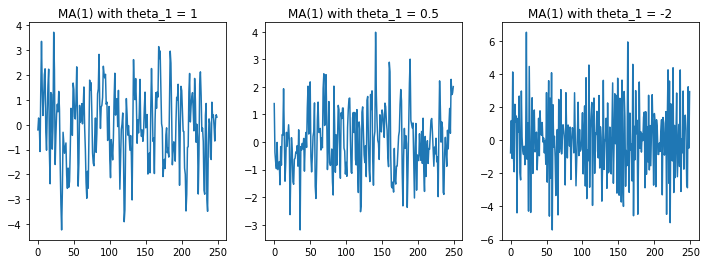

In [166]:
# MA

np.random.seed(12345)

ma_1 = gen_arma_samples(ar = [1], ma = [1,1], nobs = 250) # y_t = (1+L) epsilon_t
ma_2 = gen_arma_samples(ar = [1], ma = [1,0.5], nobs = 250) # y_t = (1+0.5L)epsilon_t
ma_3 = gen_arma_samples(ar = [1], ma = [1,-2], nobs = 250) # y_t = (1-2L) epsilon_t

fig,ax = plt.subplots(1,3, figsize = (12,4))

ax[0].plot(ma_1)
ax[0].set_title("MA(1) with theta_1 = 1")
ax[1].plot(ma_2)
ax[1].set_title("MA(1) with theta_1 = 0.5")
ax[2].plot(ma_3)
ax[2].set_title("MA(1) with theta_1 = -2")

plt.show()
 

<AxesSubplot:xlabel='Date'>

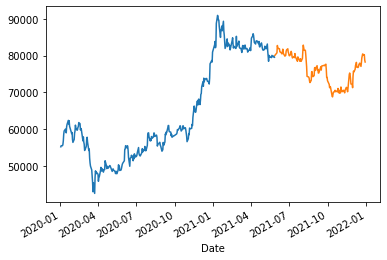

In [167]:
# ARIMA 실습(auto_arima)

import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

# df_krx = fdr.StockListing('KRX')
# df_krx[df_krx['Name'] == '삼성전자']['Symbol']

ss = fdr.DataReader('005930',"2020/01/01","2021/12/31")

y_train = ss['Close'][:int(0.7*len(ss))]
y_test = ss['Close'][int(0.7*len(ss)):]

y_train.plot()
y_test.plot()

In [168]:
# 차분 차수 찾기

kpss_ndiffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d = 6)
adf_ndiffs = ndiffs(y_train, alpha=0.05, test='adf', max_d = 6)

n_diffs = max(kpss_ndiffs, adf_ndiffs)

print(f'적정 차분 차수 {n_diffs}')

적정 차분 차수 1


auto_arima
---

- y: array 형태의 시계열 자료
- d (기본값 = none): 차분의 차수, 이를 지정하지 않으면 실행 기간이 매우 길어질 수 있음
- start_p (기본값 = 2), max_p (기본값 = 5): AR(p)를 찾을 범위 (start_p에서 max_p까지 찾는다!)
- start_q (기본값 = 2), max_q (기본값 = 5): AR(q)를 찾을 범위 (start_q에서 max_q까지 찾는다!)
- m (기본값 = 1): 계절적 차분이 필요할 때 쓸 수 있는 모수로 m=4m=4이면 분기별, m=12m=12면 월별, m=1m=1이면 계절적 특징을 띠지 않는 데이터를 의미한다. m=1이면 자동적으로 seasonal 에 대한 옵션은 False로 지정된다.
- seasonal (기본값 = True): 계절성 ARIMA 모형을 적합할지의 여부
- stepwise (기본값 = True): 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부, False면 모든 모수 조합으로 모형을 적합한다.
- trace (기본값 = False): stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용한다.

In [169]:
# auto_arima는 최적의 p,q,r을 찾아줌

model =pm.auto_arima(y = y_train,
                    d = 1,
                    start_p = 0,
                    max_p = 3,
                    start_q = 0,
                    max_q = 3,
                    seasonal = False,
                    stepwise = True,
                    trace = True
                    )

# Best model:  ARIMA(0,1,0)(0,0,0)[0]  뒤의 부분이 계절성

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5890.906, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5892.850, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5892.866, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5890.105, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5894.864, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds


In [170]:
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [171]:
y_predict = model.predict(n_periods=len(y_test))
y_predict = pd.DataFrame(y_predict, index=y_test.index, columns=['Prediction'])
y_predict

,Prediction
Date,
2021-05-28,79600.0
2021-05-31,79600.0
2021-06-01,79600.0
2021-06-02,79600.0
2021-06-03,79600.0
...,...
2021-12-24,79600.0
2021-12-27,79600.0
2021-12-28,79600.0


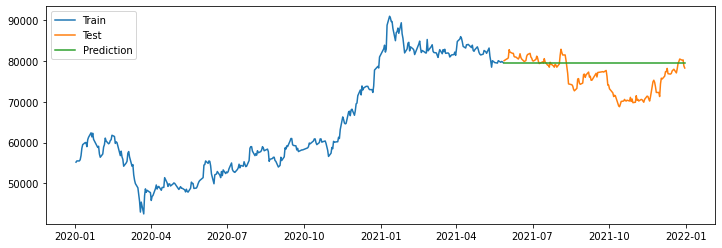

In [172]:
fig, axes = plt.subplots(figsize = (12,4))
plt.plot(y_train, label = 'Train')
plt.plot(y_test, label = 'Test')
plt.plot(y_predict, label ='Prediction')
plt.legend()
plt.show()

In [173]:
def forcast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)

    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

forcast_one_step()

(79600.0, [77251.89428339618, 81948.10571660382])

In [210]:
forcast_list = []
y_pred = []
pred_upper = []
pred_lower = []

for i in y_test:
    fc, conf = forcast_one_step()

    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    model.update(i)

In [214]:
y_pred = pd.DataFrame({'test':y_test, 'pred':y_pred})
# y_pred = y_pred.drop(['test'], inplace=True)
y_pred = y_pred['pred']
y_pred

Date
2021-05-28    78300.0
2021-05-31    80100.0
2021-06-01    80500.0
2021-06-02    80600.0
2021-06-03    80800.0
               ...   
2021-12-24    79900.0
2021-12-27    80500.0
2021-12-28    80200.0
2021-12-29    80300.0
2021-12-30    78800.0
Name: pred, Length: 149, dtype: float64

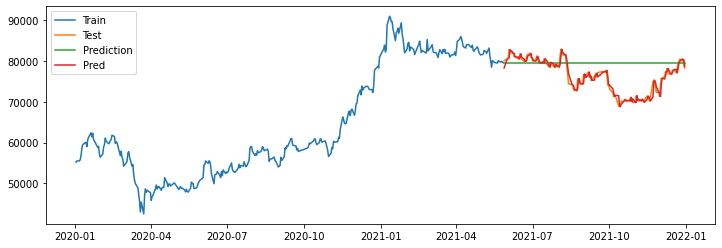

In [212]:
fig, axes = plt.subplots(figsize = (12,4))
plt.plot(y_train, label = 'Train')
plt.plot(y_test, label = 'Test')
plt.plot(y_predict, label ='Prediction')
plt.plot(y_pred, label ='Pred')
plt.legend()
plt.show()

In [226]:
import plotly.graph_objects as go
fig = go.Figure([
    # 훈련 데이터
    go.Scatter(x=y_train.index, y=y_train, name='Train', mode='lines', line=dict(color='royalblue')),
    # 테스트 데이터
    go.Scatter(x=y_test.index, y=y_test, name='Test', mode='lines', line=dict(color='rgba(0,0,30,0.5)')),
    # Predict 데이터
    go.Scatter(x=y_test.index, y=y_pred, name='Pred', mode='lines', line=dict(color='red', dash='dot', width=1)),
    # 신뢰구간
    go.Scatter(x=y_test.index.tolist() + y_test.index[::-1].tolist(), 
                y = pred_upper + pred_lower[::-1], 
                fill='toself',
                fillcolor = 'rgba(0,0,30,0.1)',
                line={'color':'rgba(0,0,0,0)'},
                hoverinfo = 'skip',
                showlegend=True)

])

fig.update_layout(height=400, width=1000, title_text='ARIMA(0,1,0)')
fig.show()